# **Lab 3: Extending Logistic Regression**
**Name(s):** Luke Voinov, Tiffany Nguyen

All the code is adapted from the following notebooks by Eric Larson:

https://github.com/eclarson/MachineLearningNotebooks/blob/master/05.%20Logistic%20Regression.ipynb

https://github.com/eclarson/MachineLearningNotebooks/blob/master/06.%20Optimization.ipynb

https://github.com/eclarson/MachineLearningNotebooks/blob/master/PDF_Slides/current%20slides/ML_4c_bfgs.pdf

## **1. Business Understanding**

For this report, we will define the classification problem as predicting whether a driver will finish on the podium (top 3) in a given race based on pre-race and qualifying data from the Formula 1 World Championship (1950-2024) dataset from Kaggle. A value of 1 represents a podium finish (1st, 2nd, or 3rd place), while a value of 0 represents a non-podium finish (all other positions, including retirements or disqualifications). Features that may be used in the model include grid position, constructor (team), track characteristics, driver performance history, and season information.

The business case for this type of model is centered on forecasting and strategic decision-making. Racing teams could use such a model to estimate the likelihood of a podium finish before the race to guide strategy, such as pit stop planning or driver expectations. Broadcasters and analysts could use the predicted probabilities to enhance pre-race coverage with data-driven insights, while sponsors and advertisers could use these forecasters to assess expected driver visibiliy and exposure.

This type of model would be used primarily for offline analysis or pre-race forecasting, not for rela-time decision-making during a race. Because podium finishes are rarely rare events, the model does not need to achieve perfect accuracy to be valuable. Instead, its usefulness lies in performing better than a naive baseline (predicting "no podium"), providing some discriminative power to identify which drivers are more likely to place highly. Even a moderate level of accuracy would provide helpful insights for teams, broadcasters, and sponsors.

In [13]:
# Import any dependencies

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import StratifiedKFold

### **1.2 Pre-processing**

- raceId: unique identifier for each race (categorical), one-hot encoded integer (ID variable)
- driverId: unique identifier for each driver (categorical), one-hot encoded integer (driver identity)
- constructorId: unique identifier for each constructor/team (categorical), one-hot encoded integer (team identity)
- grid: driver's starting position on the grid (ex, 1 = pole/1st place); numerical; integer, scaled
- year: year of the race (numerical); integer, scaled
- round: round number in the racing season (numerical); integer, scaled
- positionOrder: final finishing position of the driver (numerical); integer (used only to create target)
- podium (target): binary target including podium finish (1 = podium, 0 = not podium); categorical; binary integer/boolean

Below, we have all the CSVs loaded and we had chosen our variables from the four (results, races, drivers, and constructors). We did not consider columns such as *milliseconds*, *fastestLap*, and *status* because they depended on in-race events. Any rows that were missing *positionOrder* were dropped as these were essential for defining the target variable and key features.

The target variable for this task is **podium**, which indicates whether or not a driver finishes in the top 3 for a given race.
- ```podium = 1```: driver finished in position 1
- ```podium = 2```: driver finished in position 2
- ```podium = 3```: driver finished in position 3
- ```podium = 0```: driver finished in any other positions, including DNFs (did not finish)

This variable is derived from the ```positionOrder``` column in the Formula 1 World Championship (1950-2024) dataset.

In [14]:
# Adapted from Tiffany Nguyen's Lab 1 submission for CS 5324.

results = pd.read_csv("/Users/tiffany/Desktop/CS 5324/CS 5324 Datasets/results.csv")
races = pd.read_csv("/Users/tiffany/Desktop/CS 5324/CS 5324 Datasets/races.csv")
drivers = pd.read_csv("/Users/tiffany/Desktop/CS 5324/CS 5324 Datasets/drivers.csv")
constructors = pd.read_csv("/Users/tiffany/Desktop/CS 5324/CS 5324 Datasets/constructors.csv")

# Create full driver name column in drivers dataset
drivers['driverName'] = drivers['forename'] + ' ' + drivers['surname']

# Start with results
merged = results.copy()

# Add driver names
merged = merged.merge(drivers[['driverId', 'driverName']], on='driverId', how='left')
merged = merged.drop(columns=['driverId'])

# Add race names (for readability)
merged = merged.merge(races[['raceId', 'name', 'year', 'round']], on='raceId', how='left')
merged = merged.drop(columns=['raceId'])
merged = merged.rename(columns={'name': 'raceName'})

# Add constructor names (team)
merged = merged.merge(constructors[['constructorId', 'name']], on='constructorId', how='left')
merged = merged.drop(columns=['constructorId'])
merged = merged.rename(columns={'name': 'constructorName'})

# Create the Podium Target Variable
merged = merged.dropna(subset=['positionOrder', 'grid'])  # drop rows missing key fields
merged['podium'] = merged['positionOrder'].apply(lambda x: 1 if x <= 3 else 0)

To make reading the CSV easier for us to work with, we'll change the ```driverId``` and match it with their corresponding name, the ```raceId``` to the corresponding name, and the ```constructorId``` to their corresponding ```constructorName```. It is easy to do this since they're all in the CSVs we're working with for this report.

In [15]:
# These columns are available BEFORE the race
df = merged[[
    "raceName",           # unique race
    "driverName",         # driver identity
    "constructorName",    # team identity
    "grid",             # starting position
    "positionOrder",    # finishing position
    "year",             # year
    "round"             # round in season
]]

# Remove rows with missing or invalid grid of position values
df = df.dropna(subset=["grid", "positionOrder"])

# Create multi-class target: 3 for 1st place, 2 for 2nd, 1 for 3rd, 0 otherwise
df["podium"] = df["positionOrder"].apply(
    lambda x: 3 if x == 1 else (2 if x == 2 else (1 if x == 3 else 0))
)

# Check the unique classes in the target variable
print("Unique classes in the target variable:", df["podium"].unique())

print("Shape of data:", df.shape)
print(df.head())

# Save cleaned data to CSV
df.to_csv("/Users/tiffany/Desktop/CS 5324/CS 5324 Datasets/f1_cleaned.csv", index=False)
print("Cleaned data saved to f1_cleaned.csv")

path = "/Users/tiffany/Desktop/CS 5324/CS 5324 Datasets/f1_cleaned.csv"

Unique classes in the target variable: [3 2 1 0]
Shape of data: (26759, 8)
                raceName         driverName constructorName  grid  \
0  Australian Grand Prix     Lewis Hamilton         McLaren     1   
1  Australian Grand Prix      Nick Heidfeld      BMW Sauber     5   
2  Australian Grand Prix       Nico Rosberg        Williams     7   
3  Australian Grand Prix    Fernando Alonso         Renault    11   
4  Australian Grand Prix  Heikki Kovalainen         McLaren     3   

   positionOrder  year  round  podium  
0              1  2008      1       3  
1              2  2008      1       2  
2              3  2008      1       1  
3              4  2008      1       0  
4              5  2008      1       0  
Cleaned data saved to f1_cleaned.csv


Let's double check if there are any missing values per column.

In [16]:
# Check for missing values in the entire dataset
print(df.isnull().sum())  # Shows the count of missing values per column

# Alternatively, check if there are any missing values at all
print("Missing values =", df.isnull().values.any())  # Returns True if there are missing values

raceName           0
driverName         0
constructorName    0
grid               0
positionOrder      0
year               0
round              0
podium             0
dtype: int64
Missing values = False


Since there are no more missing data to deal with, we will check what the summary of the dataframe gives us in terms of the data types and number of non-null values.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   raceName         26759 non-null  object
 1   driverName       26759 non-null  object
 2   constructorName  26759 non-null  object
 3   grid             26759 non-null  int64 
 4   positionOrder    26759 non-null  int64 
 5   year             26759 non-null  int64 
 6   round            26759 non-null  int64 
 7   podium           26759 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 1.6+ MB


In [18]:
df.head(10)

,raceName,driverName,constructorName,grid,positionOrder,year,round,podium
0,Australian Grand Prix,Lewis Hamilton,McLaren,1,1,2008,1,3
1,Australian Grand Prix,Nick Heidfeld,BMW Sauber,5,2,2008,1,2
2,Australian Grand Prix,Nico Rosberg,Williams,7,3,2008,1,1
3,Australian Grand Prix,Fernando Alonso,Renault,11,4,2008,1,0
4,Australian Grand Prix,Heikki Kovalainen,McLaren,3,5,2008,1,0
5,Australian Grand Prix,Kazuki Nakajima,Williams,13,6,2008,1,0
6,Australian Grand Prix,Sébastien Bourdais,Toro Rosso,17,7,2008,1,0
7,Australian Grand Prix,Kimi Räikkönen,Ferrari,15,8,2008,1,0
8,Australian Grand Prix,Robert Kubica,BMW Sauber,2,9,2008,1,0
9,Australian Grand Prix,Timo Glock,Toyota,18,10,2008,1,0


Let's categorize the podium finishes and visualize it with the top 20 teams. This will make it easier for us to look at the data and what we're actually observing and trying to predict.

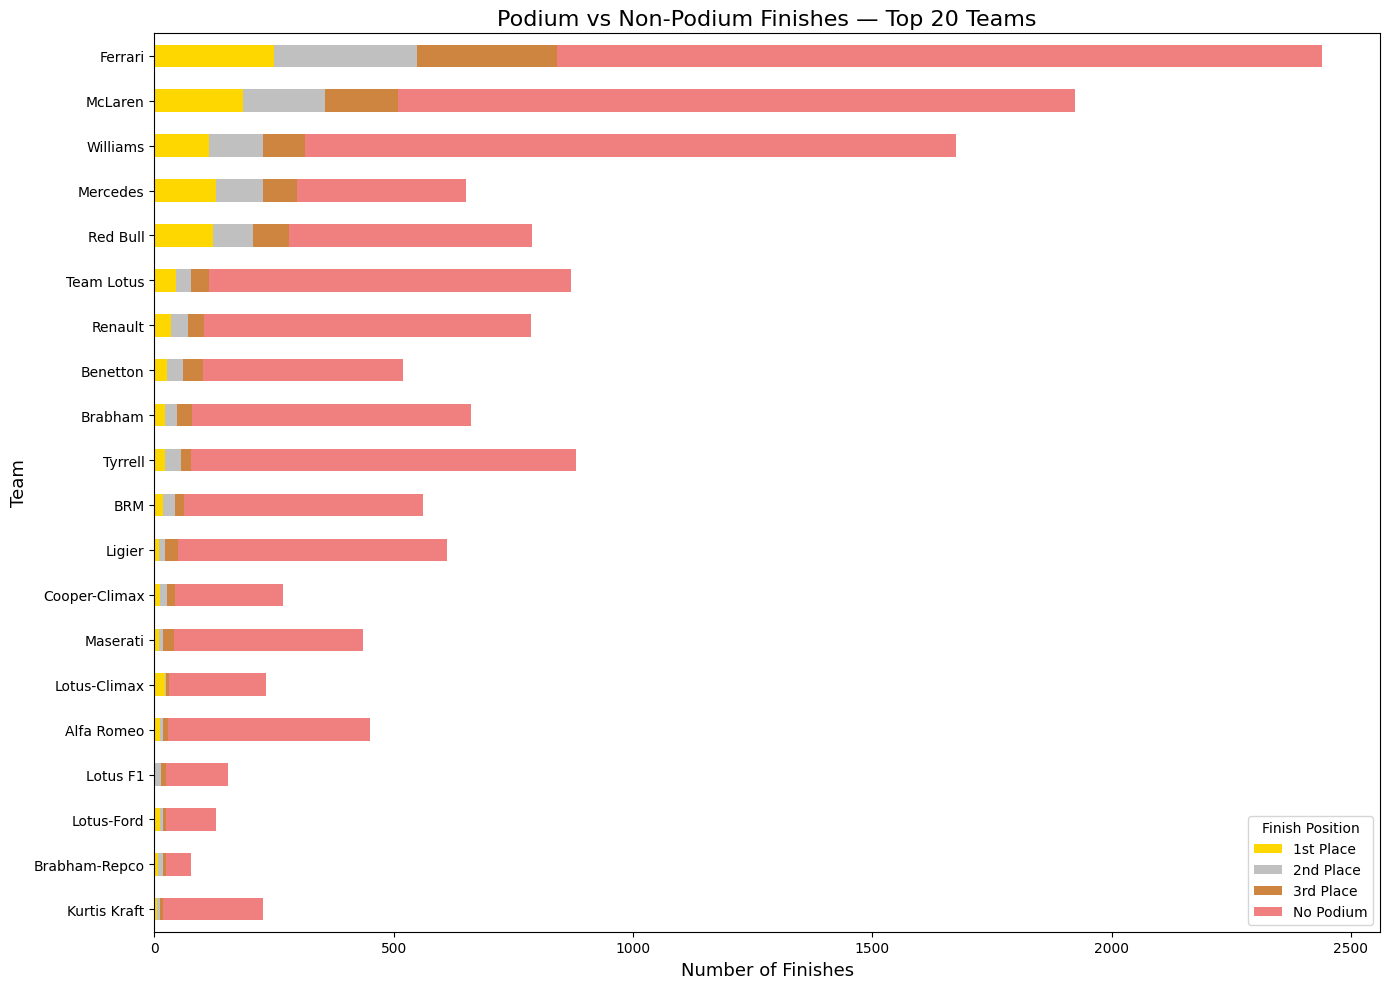

In [19]:

# Categorize podium finishes
def categorize_podium(pos):
    if pos == 1:
        return "1st Place"
    elif pos == 2:
        return "2nd Place"
    elif pos == 3:
        return "3rd Place"
    else:
        return "No Podium"

df["podium_category"] = df["positionOrder"].apply(categorize_podium)

# Aggregate counts by team and podium category
podium_counts = df.groupby(["constructorName", "podium_category"]).size().unstack(fill_value=0)

# Sort teams by total podium finishes and keep top 20
podium_counts["TotalPodiums"] = podium_counts[["1st Place", "2nd Place", "3rd Place"]].sum(axis=1)
top_teams = podium_counts.sort_values(by="TotalPodiums", ascending=False).head(20)
top_teams = top_teams.drop(columns="TotalPodiums")

# Plot stacked bar chart (horizontal)
colors = ["gold", "silver", "peru", "lightcoral"]
ax = top_teams.plot(
    kind="barh",
    stacked=True,
    figsize=(14, 10),
    color=colors
)

plt.title("Podium vs Non-Podium Finishes — Top 20 Teams", fontsize=16)
plt.ylabel("Team", fontsize=13)
plt.xlabel("Number of Finishes", fontsize=13)
plt.legend(title="Finish Position", loc="lower right")
plt.gca().invert_yaxis()  # Highest podium teams at the top
plt.tight_layout()
plt.show()


From the stacked bar chart we made, we can visually see the ratio a team has between podiums (1st place, 2nd place, and 3rd place) and no podiums. For our predictions, we should expect a higher ratio of no podiums compared to podiums based off of the chart. We can see the relative sizes of the segments within each bar to understand how the target variable is distributed across the groups (in this case, the Constructors and how they are performing overall based on podium/no podium).

The final dataset that is going to be used for classification is now ready to be used to split them into two sets: training and testing data using a 80/20 split. We defined the numerical and categorical features right before we had performed any pre-processing on our dataset. Remember that our dataset spans from 1950 to 2024. We also did not add any new categorical/numerical columns to our dataset as it was not necessary for this task. 

After we had pre-processed the dataset for it to be used for training and testing, the dataset had also been cleaned to include only the variables that are available before a race begins. Each row in the dataset represents a single driver's performance in a specific race. It also includes information such as race name, the driver's name, and the constructor (team) they were driving for. It also includes the driver's starting grid position, finishing position, the year of the race, and the round number within the season.

Our target variable is a multi-class indicator called ```podium```, which we had stated above before we pre-processed our dataset:
- ```podium = 1```: driver finished in position 1
- ```podium = 2```: driver finished in position 2
- ```podium = 3```: driver finished in position 3
- ```podium = 0```: driver finished in any other positions, including DNFs (did not finish)

All features in our final dataset were selected to reflect information known before the race so that the model can make realistic predictions without using outcome-dependent data. Categorical variables such as race name, driver name, and constructor name, will later be encoded, while numeric variables like grid position, year, and round can be scaled to support model training.

Overall, this cleaned dataset gives us a structured, pre-race snapshot of each driver's entry into a race, which we can use to train a logistic regression model to predict whether or not they will finish on the podium.

### **1.3 Splitting 80/20**

Now that the data is easier to read for us (Luke and Tiffany), we can take this data and divide it into training and testing data using an 80% training and 20% testing split.

In [20]:
from sklearn.preprocessing import StandardScaler

# Load the cleaned dataset
df = pd.read_csv(path)

# Features and target variable
X = df.drop(columns=["podium", "positionOrder"])
y = df["podium"]

# For now, we'll encode categorical variables using one-hot encoding
X = pd.get_dummies(X, columns=["raceName", "driverName", "constructorName"], drop_first=True)

# Train-test split with stratification (80% train, 20% split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df["podium"]) # stratify to maintain class distribution 

# Convert to numpy arrays with proper data types
X_train = X_train.astype(np.float32).values
X_test = X_test.astype(np.float32).values
y_train = y_train.astype(np.int32).values
y_test = y_test.astype(np.int32).values

# Scale the array
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)

Training set shape: (21407, 1126)
Test set shape: (5352, 1126)


In [21]:
# Get all one-hot encoded columns
one_hot_encoded_columns = [col for col in X.columns if col.startswith("raceName_") or col.startswith("driverName_") or col.startswith("constructorName_")]
print("One-hot encoded columns:", one_hot_encoded_columns)

X = X.drop(columns=one_hot_encoded_columns)
print("Number of one-hot encoded columns:", len(one_hot_encoded_columns))

One-hot encoded columns: ['raceName_Abu Dhabi Grand Prix', 'raceName_Argentine Grand Prix', 'raceName_Australian Grand Prix', 'raceName_Austrian Grand Prix', 'raceName_Azerbaijan Grand Prix', 'raceName_Bahrain Grand Prix', 'raceName_Belgian Grand Prix', 'raceName_Brazilian Grand Prix', 'raceName_British Grand Prix', 'raceName_Caesars Palace Grand Prix', 'raceName_Canadian Grand Prix', 'raceName_Chinese Grand Prix', 'raceName_Dallas Grand Prix', 'raceName_Detroit Grand Prix', 'raceName_Dutch Grand Prix', 'raceName_Eifel Grand Prix', 'raceName_Emilia Romagna Grand Prix', 'raceName_European Grand Prix', 'raceName_French Grand Prix', 'raceName_German Grand Prix', 'raceName_Hungarian Grand Prix', 'raceName_Indian Grand Prix', 'raceName_Indianapolis 500', 'raceName_Italian Grand Prix', 'raceName_Japanese Grand Prix', 'raceName_Korean Grand Prix', 'raceName_Las Vegas Grand Prix', 'raceName_Luxembourg Grand Prix', 'raceName_Malaysian Grand Prix', 'raceName_Mexican Grand Prix', 'raceName_Mexico

### **1.3.1 Why the 80/20 Split is Appropriate**

We argue for using an 80/20 split for this dataset.

The Formula 1 results dataset contains data from many seasons and hundreds of races dating back from 1950s, which means the sample size is large enough to allocate 20% for testing without sacrificing too much training data. Using 80% of the data for training allows for the logisitc regression model to learn from a wide range of drivers, constructors, and circuits, while 20 provides a sufficiently large and diverse set for evaluating model performance on unseen races.

Additionally, the dataset exhibits a moderate class imbalance, of which only 15% of the entires are podium finishes (top 3). By using stratified sampling, we ensure that both the training and testing sets preserve this natural imbalance. This makes our evaluation metrics more reliable and representative of real-world performance.

### **2. Modeling**


Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use programming conventions identical to scikit-learn classes. You can start with the template developed by the instructor in the course, but will need to make substantial changes. You should add the following functionality to the logistic regression classifier:

- Ability to choose one of three optimization techniques when class is instantiated: either (1) {steepest ascent}, (2) {stochastic gradient ascent or line search}, and (3) {Newton's method/Quasi Newton methods}. It is recommended to call this input to the model "solver" for the class, to mirror the convention of scikit-learn. The input should be a string, as is used in scikit. 
- Add support for additional regularization penalties. that is, update the gradient calculation to include a customizable regularization term (either using {no regularization}, {L1 regularization}, {L2 regularization}, or {both L1 and L2 regularization}). The choice of regularization should be set during the instantiation of the class. Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.  

In [22]:
import numpy as np
class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta)) 
    
    @staticmethod
    def _add_intercept(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    # public:
    def predict_proba(self, X, add_intercept=True):
        # add bias term if requested
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction


In [23]:
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    def __init__(self, eta=0.01, iterations=20, C=0.0):
        super().__init__(eta, iterations)
        self.C = C
    
    def fit(self, X, y):
        Xb = self._add_intercept(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += self.eta * gradient # gradient ascent
    
    def _get_gradient(self,X,y):
        # basic gradient - to be overridden by subclasses
        ydiff = y-self.predict_proba(X,add_intercept=False).ravel()
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        return gradient.reshape(self.w_.shape)

In [24]:
# now lets do some vectorized coding
from scipy.special import expit

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        return expit(theta) #1/(1+np.exp(-theta))
    
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_intercept=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        return gradient.reshape(self.w_.shape)

#### **L1 Norm**

In [25]:
class L1BinaryLogisticRegression(VectorBinaryLogisticRegression):
    # extend init functions
    def __init__(self, eta=0.01, iterations=20, C=0.0, **kwds):        
        # need to add to the original initializer 
        self.C = C
        # but keep other keywords
        super().__init__(eta=eta, iterations=iterations, C=C, **kwds) # call parent initializer
        
        
    # extend previous class to change functionality
    def _get_gradient(self,X,y):
        # call get gradient from previous class
        gradient = super()._get_gradient(X,y)
        
        # add in regularization. np.sign does an element-wise comparision for >, < and = 0
        gradient[1:] -= self.C * np.sign(self.w_[1:])

        return gradient
        

#### **L2 Norm**

In [26]:
class L2BinaryLogisticRegression(VectorBinaryLogisticRegression):
    # extend init functions
    def __init__(self, eta=0.01, iterations=20, C=0.0, **kwds):        
        # need to add to the original initializer 
        self.C = C
        # but keep other keywords
        super().__init__(eta=eta, iterations=iterations, C=C, **kwds) # call parent initializer
        
        
    # extend previous class to change functionality
    def _get_gradient(self,X,y):
        # call get gradient from previous class
        gradient = super()._get_gradient(X,y)
        
        # add in regularization
        gradient[1:] += -2 * self.C * self.w_[1:] 
        return gradient
        

#### **L12 Norm (elasticnet)**

In [27]:
class L12BinaryLogisticRegression(VectorBinaryLogisticRegression):
    # extend init functions
    def __init__(self, eta=0.01, iterations=20, C=0.0, **kwds):        
        # need to add to the original initializer 
        self.C = C
        # but keep other keywords
        super().__init__(eta=eta, iterations=iterations, C=C, **kwds) # call parent initializer
        
        
    # extend previous class to change functionality
    def _get_gradient(self,X,y):
        # call get gradient from previous class
        gradient = super()._get_gradient(X,y)
        
        # add in regularization (to all except bias term)
        # L1 part
        gradient[1:] -= self.C * np.sign(self.w_[1:])
        # L2 part  
        gradient[1:] += -2 * self.C * self.w_[1:]

        return gradient
        

#### **Steepest Ascent (sa)**

In [28]:
class SteepestAscentLogisticRegression(BinaryLogisticRegression):
    
    def __init__(self, eta=0.01, iterations=20, C=0.0, **kwds):
        super().__init__(eta, iterations, C)

    #nothing special, just regular gradient descent
        

#### **Line Search (ls)**

In [29]:
# and we can update this to use a line search along the gradient like this:
from scipy.optimize import minimize_scalar
import copy
from numpy import ma # (masked array) this has most numpy functions that work with NaN data.
class LineSearchLogisticRegression(BinaryLogisticRegression):
    
    # define custom line search for problem
    def __init__(self, line_iters=0.0, **kwds):        
        self.line_iters = line_iters
        # but keep other keywords
        super().__init__(**kwds) # call parent initializer
    
    # this defines the function with the first input to be optimized
    # therefore eta will be optimized, with all inputs constant
    @staticmethod
    def objective_function(eta,X,y,w,grad,C):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        # the line search is looking for minimization, so take the negative of l(w)
        return -np.sum(ma.log(g[y==1]))-ma.sum(ma.log(1-g[y==0])) + C*sum(wnew[1:]**2)
    
        
    def fit(self, X, y):
        Xb = self._add_intercept(X) # add bias term
        
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb,y)
            # minimization is in opposite direction
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.line_iters} # unclear exactly what this should be
            res = minimize_scalar(self.objective_function, # objective function to optimize
                                  bounds=(0,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,self.C), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ -= gradient*eta # set new function values
            # subtract to minimize
                 

#### **Quasi-Newton (bfgs)**

In [30]:
# for this, we won't perform our own BFGS implementation 
# (it takes a fair amount of code and understanding, which we haven't setup yet)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs # maybe the most common bfgs algorithm in the world
from numpy import ma
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        return -ma.sum(ma.log(g[y==1]))-ma.sum(ma.log(1-g[y==0])) + C*sum(w**2) 
        #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_intercept(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))

In [31]:
class LogisticRegression:
    def __init__(self, eta=0.01, iterations=20, solver='sa', penalty='none', C=1.0):
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        self.penalty = penalty
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    @property
    def coef_(self):
        if(hasattr(self,'w_')):
            return self.w_[:,1:]
        else:
            return None

    @property
    def intercept_(self):
        if(hasattr(self,'w_')):
            return self.w_[:,0]
        else:
            return None
    
    def _get_binary_classifier(self):
        # Base classifier selection based on penalty
        if self.penalty == 'l1':
            base_class = L1BinaryLogisticRegression
        elif self.penalty == 'l2':
            base_class = L2BinaryLogisticRegression
        elif self.penalty == 'elasticnet':
            base_class = L12BinaryLogisticRegression
        else:  # 'none'
            base_class = VectorBinaryLogisticRegression
        
        # each 'regularized' class will inherit appropriate gradients (regularization) and fit methods (solver)
        if self.solver == 'sa':
            class RegularizedSteepestAscent(SteepestAscentLogisticRegression, base_class):
                def __init__(self, **kwargs):
                    super().__init__(**kwargs)
            return RegularizedSteepestAscent(eta=self.eta, iterations=self.iters, C=self.C)
        elif self.solver == 'linesearch' or self.solver == 'ls':
            class RegularizedLineSearch(LineSearchLogisticRegression, base_class):
                def __init__(self, **kwargs):
                    super().__init__(**kwargs)
            return RegularizedLineSearch(eta=self.eta, iterations=self.iters, line_iters=8, C=self.C)
        elif self.solver == 'bfgs':
            class RegularizedBFGS(BFGSBinaryLogisticRegression, base_class):
                def __init__(self, **kwargs):
                    super().__init__(**kwargs)
            return RegularizedBFGS(eta=self.eta, iterations=self.iters, C=self.C)
        else:
            print("Unknown solver:", self.solver)
    
    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i, yval in enumerate(self.unique_): # for each unique value
            y_binary = (y == yval) # create a binary problem
            # Get the appropriate binary classifier for this solver/penalty combination
            blr = self._get_binary_classifier()
            blr.fit(X, y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row
    



#### **2.1 Finding the best C and Eta**
Train your classifier to achieve as good as possible generalization performance. That is, adjust the optimization technique, the type of regularization, and the value of the regularization cost "C" to achieve the best performance on your test set. Visualize the performance of the classifier versus the parameters you investigated. 


First, we will use the default hyperparameters to see how well each variation of the model works. We will then find the optimal hyperparameter values and see how everything works from there.

Wanted values:
0 (no podium): 4672
1 (podium): 227
2 (podium): 227
3 (podium): 226 

Predicted values:
0 (no podium): 5352
1 (podium): 0
2 (podium): 0
3 (podium): 0


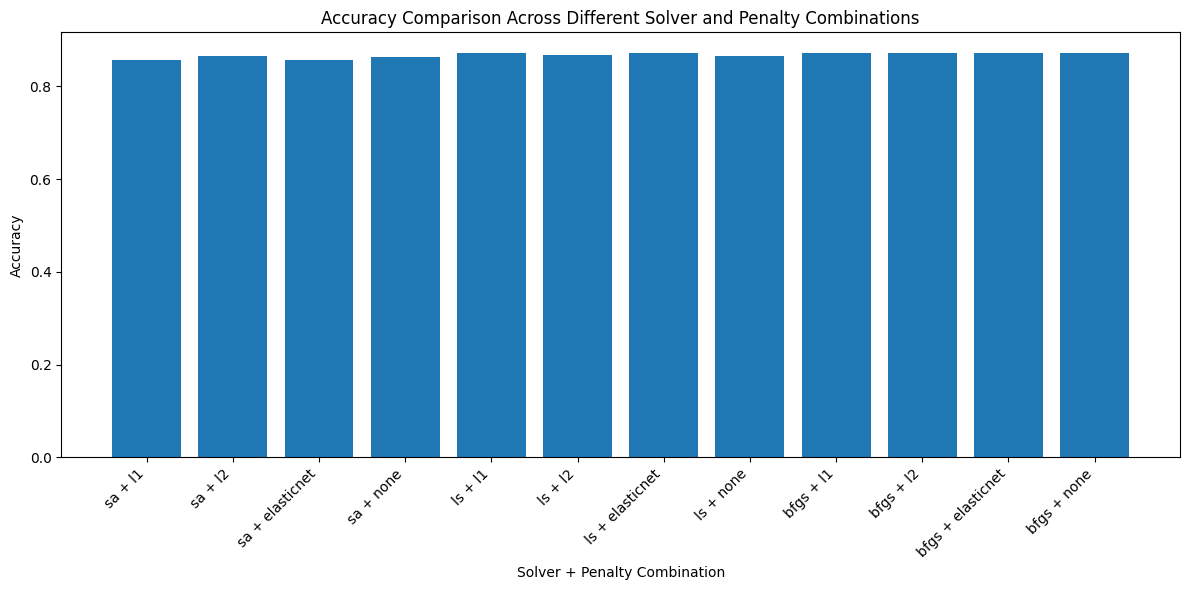

In [32]:
from sklearn.metrics import accuracy_score

solvers = ['sa','ls','bfgs']
penalties = ['l1','l2','elasticnet','none']

combined_sp = []
accuracies = []

# defualt values
eta = 0.01
iterations = 20
C = 0.1

for s in solvers:
     for p in penalties:
        combination = s + " + " + p
        combined_sp.append(combination)

        lr = LogisticRegression(eta,iterations,s,p,C)
        lr.fit(X_train_scaled,y_train)

        yhat = lr.predict(X_test_scaled)
        acc = accuracy_score(y_test,yhat)
        accuracies.append(acc)

print("Wanted values:")
print("0 (no podium):", np.sum(y_test == 0))
print("1 (podium):", np.sum(y_test == 1))
print("2 (podium):", np.sum(y_test == 2))
print("3 (podium):", np.sum(y_test == 3),"\n")

print("Predicted values:")
print("0 (no podium):", np.sum(yhat == 0))
print("1 (podium):", np.sum(yhat == 1))
print("2 (podium):", np.sum(yhat == 2))
print("3 (podium):", np.sum(yhat == 3))

plt.figure(figsize=(12, 6))
plt.bar(range(len(combined_sp)), accuracies)
plt.xlabel('Solver + Penalty Combination')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Different Solver and Penalty Combinations')
plt.xticks(range(len(combined_sp)), combined_sp, rotation=45, ha='right')
plt.tight_layout()
plt.show()

    


As we can see, the different models vary around 85-87% accuracy. Is it possible to make them have a higher accuracy?

To select hyperparameters, we will determine the best ones (e.g. eta, C, and iterations) for Steepest Ascent with l2 penalty. These parameters should generalize well for other methods and penalties.

In the following sections of code we look for the ideal C by iterating through multiple number in the range of 0 - 100 and plot out the model's accuracy with respect to the particular C.

In [33]:
%%time
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score

X_cv = X_train_scaled 
y_cv = y_train         

num_cv_iterations = 5
cv_object = ShuffleSplit(n_splits=num_cv_iterations, test_size=0.3, random_state=42)

def lr_explor(cost):
    # Use faster parameters for quick evaluation
    lr_clf = LogisticRegression(eta=0.5, iterations=20, solver='sa', penalty='l2', C=float(cost))
    acc = []
    
    for train_indices, test_indices in cv_object.split(X_cv, y_cv):
        # Train on subset
        lr_clf.fit(X_cv[train_indices], y_cv[train_indices])
        # Predict on validation set
        y_hat = lr_clf.predict(X_cv[test_indices])
        # Calculate accuracy
        acc.append(accuracy_score(y_cv[test_indices], y_hat))
    
    return np.array(acc)

costs = np.logspace(-3, 2, 15)
print("Testing C values:", costs)

accs = []
for i, c in enumerate(costs):
    print(f"Processing C={c:.4f} ({i+1}/{len(costs)})", end=" ")
    cv_scores = lr_explor(c)
    accs.append(cv_scores)
    print(f"- Mean accuracy: {cv_scores.mean():.4f}")

print("\nCross-validation complete!")

Testing C values: [1.00000000e-03 2.27584593e-03 5.17947468e-03 1.17876863e-02
 2.68269580e-02 6.10540230e-02 1.38949549e-01 3.16227766e-01
 7.19685673e-01 1.63789371e+00 3.72759372e+00 8.48342898e+00
 1.93069773e+01 4.39397056e+01 1.00000000e+02]
Processing C=0.0010 (1/15) - Mean accuracy: 0.8686
Processing C=0.0023 (2/15) - Mean accuracy: 0.8688
Processing C=0.0052 (3/15) - Mean accuracy: 0.8694
Processing C=0.0118 (4/15) - Mean accuracy: 0.8708
Processing C=0.0268 (5/15) - Mean accuracy: 0.8725
Processing C=0.0611 (6/15) - Mean accuracy: 0.8726
Processing C=0.1389 (7/15) - Mean accuracy: 0.8729
Processing C=0.3162 (8/15) - Mean accuracy: 0.8729
Processing C=0.7197 (9/15) - Mean accuracy: 0.8729
Processing C=1.6379 (10/15) - Mean accuracy: 0.8729
Processing C=3.7276 (11/15) - Mean accuracy: 0.4015
Processing C=8.4834 (12/15) - Mean accuracy: 0.4025
Processing C=19.3070 (13/15) - Mean accuracy: 0.4026
Processing C=43.9397 (14/15) - Mean accuracy: 0.4023
Processing C=100.0000 (15/15) -

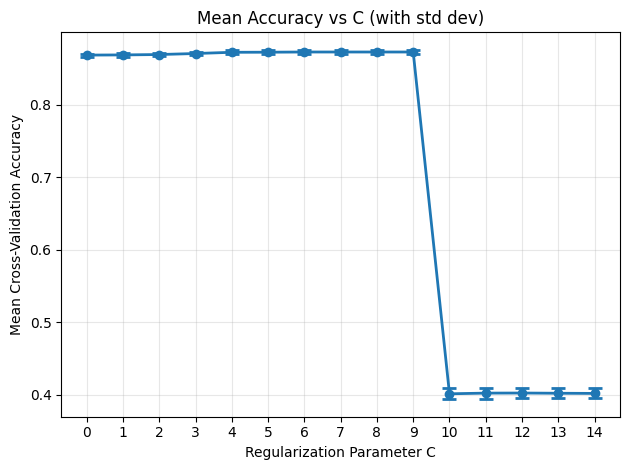


=== CROSS-VALIDATION RESULTS SUMMARY ===
C=0.0010: Mean=0.8686, Std=0.0022
C=0.0023: Mean=0.8688, Std=0.0023
C=0.0052: Mean=0.8694, Std=0.0023
C=0.0118: Mean=0.8708, Std=0.0025
C=0.0268: Mean=0.8725, Std=0.0028
C=0.0611: Mean=0.8726, Std=0.0031
C=0.1389: Mean=0.8729, Std=0.0030
C=0.3162: Mean=0.8729, Std=0.0030
C=0.7197: Mean=0.8729, Std=0.0030
C=1.6379: Mean=0.8729, Std=0.0030
C=3.7276: Mean=0.4015, Std=0.0075
C=8.4834: Mean=0.4025, Std=0.0076
C=19.3070: Mean=0.4026, Std=0.0070
C=43.9397: Mean=0.4023, Std=0.0069
C=100.0000: Mean=0.4021, Std=0.0070

Best C value: 0.1389 with mean accuracy: 0.8729


In [34]:
# Enhanced visualization of cross-validation results
from matplotlib import pyplot as plt
%matplotlib inline

# Create subplots for better visualization
plt.figure()

# Line plot showing mean accuracy and confidence intervals
mean_accs = [np.mean(acc_list) for acc_list in accs]
std_accs = [np.std(acc_list) for acc_list in accs]

plt.errorbar(range(len(costs)), mean_accs, yerr=std_accs, 
             marker='o', capsize=5, capthick=2, linewidth=2)
plt.xticks(range(len(costs)))
plt.xlabel('Regularization Parameter C')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Mean Accuracy vs C (with std dev)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary of best performing C values
print("\n=== CROSS-VALIDATION RESULTS SUMMARY ===")
for i, (c, acc_list) in enumerate(zip(costs, accs)):
    mean_acc = np.mean(acc_list)
    std_acc = np.std(acc_list)
    print(f"C={c:.4f}: Mean={mean_acc:.4f}, Std={std_acc:.4f}")

# Find and display best C value
best_idx = np.argmax(mean_accs)
best_c = costs[best_idx]
best_acc = mean_accs[best_idx]
print(f"\nBest C value: {best_c:.4f} with mean accuracy: {best_acc:.4f}")

When we plot these values out we see that an increasing C steadily increases the accuracy from 86% to 87% in the range of C = [0.001,1.6379]. A good C is therefore somewhere in this range. C becomes too large at 3.7, dropping to 40% accuracy, which is worse than chance. This means that the model's weights are overly toned down in favor of a smooth sigmoid.

In the following sections of code we use the same method to find the optimal eta.

In [35]:
%%time
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score

X_cv = X_train_scaled 
y_cv = y_train         

num_cv_iterations = 5
cv_object = ShuffleSplit(n_splits=num_cv_iterations, test_size=0.3, random_state=42)

def lr_explor(cost):
    # Use faster parameters for quick evaluation
    lr_clf = LogisticRegression(eta=float(cost), iterations=20, solver='sa', penalty='l2', C=0.1389)
    acc = []
    
    for train_indices, test_indices in cv_object.split(X_cv, y_cv):
        # Train on subset
        lr_clf.fit(X_cv[train_indices], y_cv[train_indices])
        # Predict on validation set
        y_hat = lr_clf.predict(X_cv[test_indices])
        # Calculate accuracy
        acc.append(accuracy_score(y_cv[test_indices], y_hat))
    
    return np.array(acc)

costs = np.logspace(-3, 2, 15)
print("Testing eta values:", costs)

accs = []
for i, e in enumerate(costs):
    cv_scores = lr_explor(e)
    accs.append(cv_scores)

print("\nCross-validation complete!")

Testing eta values: [1.00000000e-03 2.27584593e-03 5.17947468e-03 1.17876863e-02
 2.68269580e-02 6.10540230e-02 1.38949549e-01 3.16227766e-01
 7.19685673e-01 1.63789371e+00 3.72759372e+00 8.48342898e+00
 1.93069773e+01 4.39397056e+01 1.00000000e+02]

Cross-validation complete!
CPU times: user 15min 41s, sys: 17min 57s, total: 33min 38s
Wall time: 3min 44s


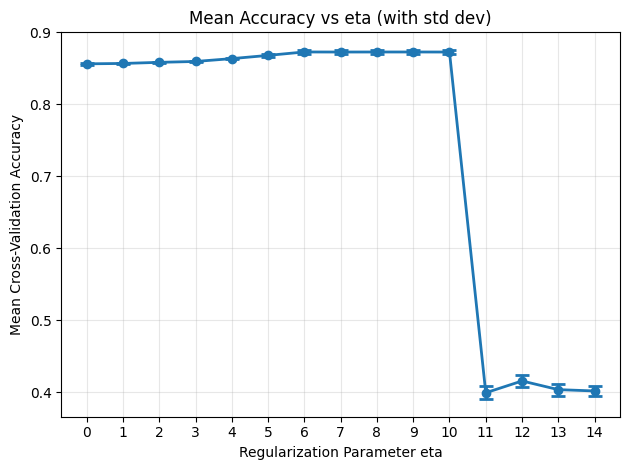


=== CROSS-VALIDATION RESULTS SUMMARY ===
eta=0.0010: Mean=0.8564, Std=0.0013
eta=0.0023: Mean=0.8569, Std=0.0012
eta=0.0052: Mean=0.8585, Std=0.0008
eta=0.0118: Mean=0.8597, Std=0.0011
eta=0.0268: Mean=0.8636, Std=0.0008
eta=0.0611: Mean=0.8681, Std=0.0018
eta=0.1389: Mean=0.8729, Std=0.0028
eta=0.3162: Mean=0.8728, Std=0.0031
eta=0.7197: Mean=0.8729, Std=0.0030
eta=1.6379: Mean=0.8729, Std=0.0030
eta=3.7276: Mean=0.8728, Std=0.0030
eta=8.4834: Mean=0.3993, Std=0.0090
eta=19.3070: Mean=0.4157, Std=0.0086
eta=43.9397: Mean=0.4037, Std=0.0082
eta=100.0000: Mean=0.4018, Std=0.0074

Best eta value: 0.1389 with mean accuracy: 0.8729


In [36]:
# Enhanced visualization of cross-validation results
from matplotlib import pyplot as plt
%matplotlib inline

# Create subplots for better visualization
plt.figure()

# Line plot showing mean accuracy and confidence intervals
mean_accs = [np.mean(acc_list) for acc_list in accs]
std_accs = [np.std(acc_list) for acc_list in accs]

plt.errorbar(range(len(costs)), mean_accs, yerr=std_accs, 
             marker='o', capsize=5, capthick=2, linewidth=2)
plt.xticks(range(len(costs)))
plt.xlabel('Regularization Parameter eta')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Mean Accuracy vs eta (with std dev)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary of best performing C values
print("\n=== CROSS-VALIDATION RESULTS SUMMARY ===")
for i, (e, acc_list) in enumerate(zip(costs, accs)):
    mean_acc = np.mean(acc_list)
    std_acc = np.std(acc_list)
    print(f"eta={e:.4f}: Mean={mean_acc:.4f}, Std={std_acc:.4f}")

# Find and display best eya value
best_idx = np.argmax(mean_accs)
best_eta = costs[best_idx]
best_acc = mean_accs[best_idx]
print(f"\nBest eta value: {best_eta:.4f} with mean accuracy: {best_acc:.4f}")

When we plot these values out we see that an increasing eta steadily increases the accuracy from 86% to 87% in the range of C = [0.001,3.7276]. A good eta is therefore somewhere in this range. Eta becomes too large at 8.4, dropping to 39% accuracy, which is worse than chance. This means the model jumps too far in the gradient descent.

Based on these results, a good C value is 0.1389, a good iteration is always high (>= 50), and a good eta is 0.1389. Thus, I will select an eta = 0.1389, iteration = 50, and C = 0.1389. See below how this changes our previous results.

Wanted values:
0 (no podium): 4672
1 (podium): 227
2 (podium): 227
3 (podium): 226 

Predicted values:
0 (no podium): 5352
1 (podium): 0
2 (podium): 0
3 (podium): 0


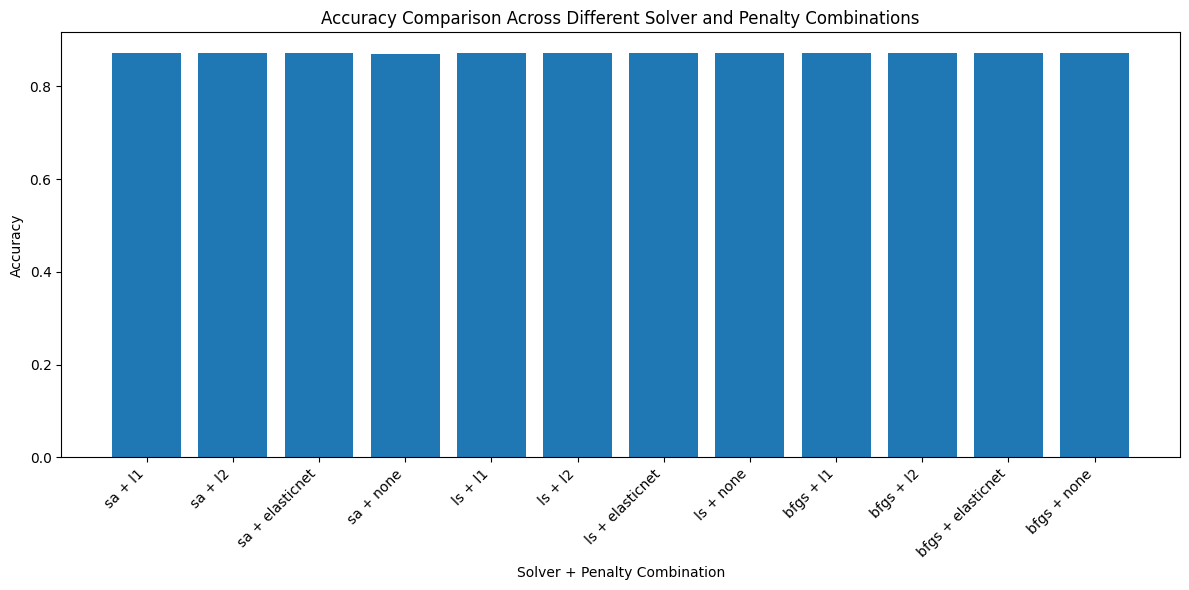

In [37]:
solvers = ['sa','ls','bfgs']
penalties = ['l1','l2','elasticnet','none']

combined_sp = []
accuracies = []

eta = 0.1389
iterations = 50
C = 0.1389

for s in solvers:
    for p in penalties:
        combined_sp.append(s + " + " + p)
        lr = LogisticRegression(eta,iterations,s,p,C)
        lr.fit(X_train_scaled,y_train)

        yhat = lr.predict(X_test_scaled)
        acc = accuracy_score(y_test,yhat)
        accuracies.append(acc)


print("Wanted values:")
print("0 (no podium):", np.sum(y_test == 0))
print("1 (podium):", np.sum(y_test == 1))
print("2 (podium):", np.sum(y_test == 2))
print("3 (podium):", np.sum(y_test == 3),"\n")

print("Predicted values:")
print("0 (no podium):", np.sum(yhat == 0))
print("1 (podium):", np.sum(yhat == 1))
print("2 (podium):", np.sum(yhat == 2))
print("3 (podium):", np.sum(yhat == 3))

plt.figure(figsize=(12, 6))
plt.bar(range(len(combined_sp)), accuracies)
plt.xlabel('Solver + Penalty Combination')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Different Solver and Penalty Combinations')
plt.xticks(range(len(combined_sp)), combined_sp, rotation=45, ha='right')
plt.tight_layout()
plt.show()


  Solver  Average Training Time (s)  Min Training Time (s)  \
0     sa                   0.011493               0.003234   
1     ls                   0.007345               0.004864   
2   bfgs                   0.004829               0.003282   

   Max Training Time (s)  
0               0.033542  
1               0.011901  
2               0.008006  


/var/folders/07/1_cm7qnd2mg18rts7n3nf9hw0000gn/T/ipykernel_93347/2958069924.py:15: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-theta))
/var/folders/07/1_cm7qnd2mg18rts7n3nf9hw0000gn/T/ipykernel_93347/2958069924.py:15: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-theta))
/var/folders/07/1_cm7qnd2mg18rts7n3nf9hw0000gn/T/ipykernel_93347/2958069924.py:15: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-theta))


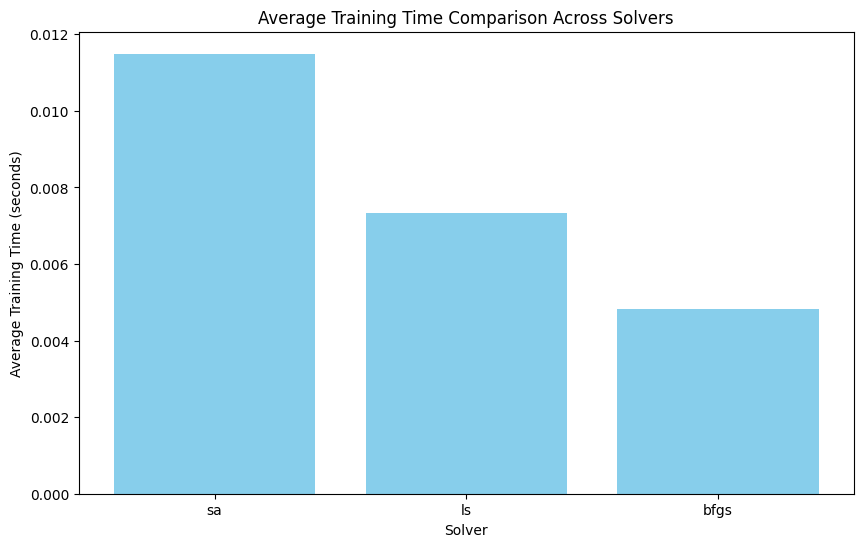

In [38]:
# One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True)  # Convert categorical columns to numerical

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Ensure training_time_results is initialized
training_time_results = []

for solver in solvers:
    training_times = []
    
    for train_idx, test_idx in cv.split(X, y):
        # Ensure X and y are NumPy arrays
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]  # Use .iloc if X is a DataFrame
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Convert to NumPy arrays
        X_train = np.array(X_train, dtype=float)  # Ensure float type for numerical operations
        X_test = np.array(X_test, dtype=float)
        y_train = np.array(y_train, dtype=float)
        y_test = np.array(y_test, dtype=float)
        
        # Measure training time
        start_time = time.time()
        
        # Use the custom logistic regression implementation
        model = BinaryLogisticRegression(eta=0.01, iterations=20, C=0.1)
        model.fit(X_train, y_train)
        
        end_time = time.time()
        training_time = end_time - start_time
        training_times.append(training_time)
    
    # Store average training time for this solver
    training_time_results.append({
        "Solver": solver,
        "Average Training Time (s)": sum(training_times) / len(training_times),
        "Min Training Time (s)": min(training_times),
        "Max Training Time (s)": max(training_times)
    })

# Convert results to a DataFrame
training_time_df = pd.DataFrame(training_time_results)

# Print results
print(training_time_df)

# Plot training time comparison
plt.figure(figsize=(10, 6))
plt.bar(training_time_df["Solver"], training_time_df["Average Training Time (s)"], color="skyblue")
plt.xlabel("Solver")
plt.ylabel("Average Training Time (seconds)")
plt.title("Average Training Time Comparison Across Solvers")
plt.show()

What we did above is to compare the average training time comparison across all 3 of the solvers we have: ```sa```, ```ls```, and ```bfgs```. From the chart, we can see that the ```bfgs``` solver is the fastest with the average of 0.004829 seconds and the slowest solver is ```sa``` with 0.011493 seconds.

### **2.2 Is our method of selecting hyper parameters justified?**


*Answer the following question in your lab report: Is your method of selecting hyper parameters justified? That is, do you think there is any "data snooping" involved with this method of tuning hyper parameters?*

We believe our method for selecting hyper parameters is justified because it provides a nice sample within a reasonable range of possible eta and C values. It allows us to see in between which values the most reasonable hyper parameter selection would be. While our eta and C turn out to optimally be the same value according to our selection method, we understand that this is only because we sampled at 15 discrete point. We suspect that if we were more granular the values would be different, but only slightly. At the very least we can say that the optimal C and eta hyper parameters are within the same order of magnitude of each other.

Notice now that each solver + penalty is comparable in accuracy with the rest, unlike when we used default hyperparameters. Also notice that the the ones that were already high in accuracy didn't go up higher. This suggests that the eta and C values were well chosen and 87% is the max accuracy that can be achieved.


*Compare the performance of your "best" logistic regression model to a logistic regression model from scikit-learn. Visualize the performance differences in terms of training time and classification performance. Discuss the results. Most points for this come from the discussion.*

It looks like most of our models reach the same accuracy so our choice of "best" model here is somewhat arbitrary. We settle for BFGS with l2 regularization.

In [40]:
import time
from sklearn.metrics import accuracy_score

eta = 0.1389
iterations = 50
C = 0.1389

start_time = time.time() # start time before initializing
lr = LogisticRegression(eta,iterations,solver="bfgs",penalty="l2",C=C)
lr.fit(X_train_scaled,y_train)

yhat = lr.predict(X_test_scaled)
training_time = time.time() - start_time # end time after predicting


# Store results
comp_acc = []
comp_train_times = []

acc = accuracy_score(y_test,yhat)
comp_acc.append(acc)
comp_train_times.append(training_time)

print(f"Training time: {training_time:.4f} seconds")
print("Accuracy:", acc)


print("Wanted values:")
print("0 (no podium):", np.sum(y_test == 0))
print("1 (podium):", np.sum(y_test == 1))
print("2 (podium):", np.sum(y_test == 2))
print("3 (podium):", np.sum(y_test == 3),"\n")

print("Predicted values:")
print("0 (no podium):", np.sum(yhat == 0))
print("1 (podium):", np.sum(yhat == 1))
print("2 (podium):", np.sum(yhat == 2))
print("3 (podium):", np.sum(yhat == 3))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 21407 but corresponding boolean dimension is 21408

In [41]:
from sklearn.linear_model import LogisticRegression as SKLogisticRegression

start_time = time.time() # start time before initializing
lr_sk = SKLogisticRegression(solver='liblinear') # all params default

lr_sk.fit(X_train_scaled,y_train)

yhat = lr_sk.predict(X_test_scaled)
training_time = time.time() - start_time #end time after predicting

acc = accuracy_score(y_test,yhat)
print('Accuracy: ',acc)

comp_acc.append(acc)
comp_train_times.append(training_time)

print("Wanted values:")
print("0 (no podium):", np.sum(y_test == 0))
print("1 (podium):", np.sum(y_test == 1))
print("2 (podium):", np.sum(y_test == 2))
print("3 (podium):", np.sum(y_test == 3),"\n")

print("Predicted values:")
print("0 (no podium):", np.sum(yhat == 0))
print("1 (podium):", np.sum(yhat == 1))
print("2 (podium):", np.sum(yhat == 2))
print("3 (podium):", np.sum(yhat == 3))

ValueError: Found input variables with inconsistent numbers of samples: [21407, 21408]

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar([0,1], comp_train_times)
plt.ylabel('Time (seconds)')
plt.title('Training Time: SKlearn vs Custom BFGS')
plt.xticks([0,1], labels=[f"Custom BFGS", f"SKlearn"], rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar([0,1], comp_acc)
plt.ylabel('Accuracy')
plt.title('Accuracy: SKlearn vs Custom BFGS')
plt.xticks([0,1], labels=[f"Custom BFGS", f"SKlearn"], rotation=45, ha='right')
plt.tight_layout()
plt.show()


NameError: name 'comp_train_times' is not defined

<Figure size 1200x600 with 0 Axes>

Surprisingly, our implementation is somehow faster than sklearn's! This is potentially because we are using BFGS while sklearn is using liblinear. At the same time, sklearn is able to classify some points into categories other than non-podium, so while its accuracy may be portrayed as slightly smaller relative to our bfgs, if we wanted at least some chance at classifying a non-podium we would use sklearn's implementation. It is probably slower than our implementation because it does a better job at achiveing more accuracy.

#### **2.3 Why is Scikit doing as poor of a job as us?**

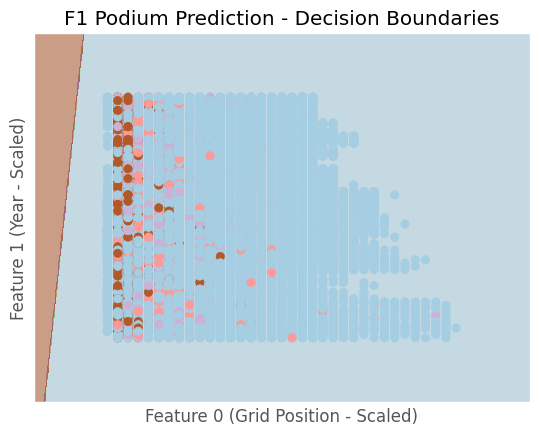

In [29]:
# linear boundaries visualization from sklearn documentation
from matplotlib import pyplot as plt
import copy
%matplotlib inline
plt.style.use('ggplot')

def plot_decision_boundaries(lr,Xin,y,title=''):
    # Handle both DataFrame and numpy array inputs
    if hasattr(Xin, 'values'):
        Xb = Xin.values[:, :2]  # For pandas DataFrame
    else:
        Xb = Xin[:, :2]  # For numpy array
    
    lr.fit(Xb, y)  # train only on two features

    h=0.01
    # create a mesh to plot in
    x_min, x_max = Xb[:, 0].min() - 1, Xb[:, 0].max() + 1
    y_min, y_max = Xb[:, 1].min() - 1, Xb[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # get prediction values
    Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

    # Plot also the training points
    plt.scatter(Xb[:, 0], Xb[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('Feature 0 (Grid Position - Scaled)')
    plt.ylabel('Feature 1 (Year - Scaled)')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(title if title else 'F1 Podium Prediction - Decision Boundaries')
    plt.show()
    
lr = LogisticRegression(0.1,1500) # this is still OUR LR implementation, not sklearn
plot_decision_boundaries(lr, X_train_scaled, y_train)

This seems to suggest that the values aren't very correlated! We can confirm this with a correlation matrix

<Axes: >

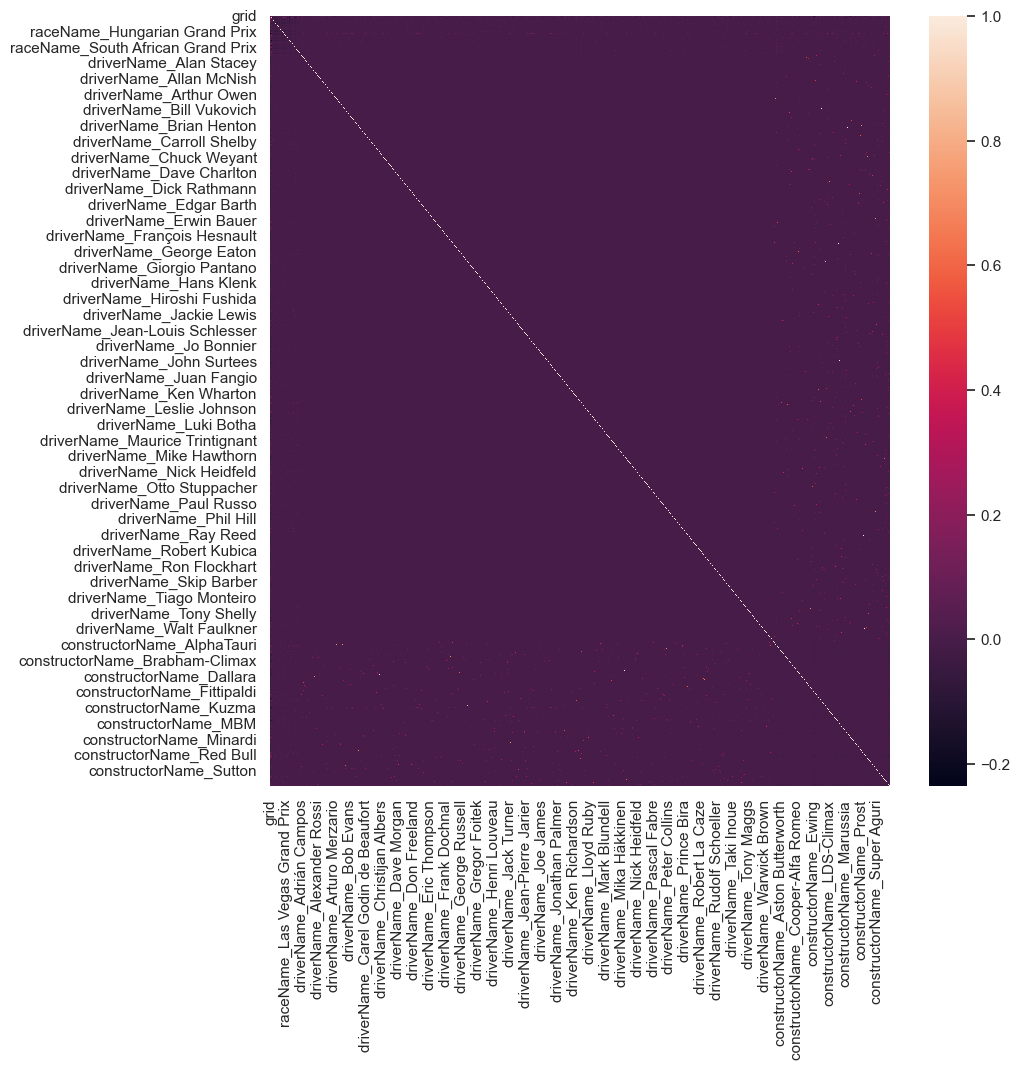

In [62]:
cmap = sns.set_theme(style="darkgrid") # one of the many styles to plot using


f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(X[:].corr(), cmap=cmap, annot=False)

This matrix suggests that people aren't correlated with each other (all purple comparing one person to another) but are more correalted with a company/constructor (can see some red and white patches in the area of people and constructors).

#### **Exceptional Work**
*Option One: Update your logistic regression code to use parallelization. This could be achieved using your own methods or using NVIDIA accelerations discussed in class. Compare the performances of your method with and without parallelization. Comparisons should be detailed.*

See other notebook (used in google colab)